# Imports

In [54]:
import json 
import numpy as np
import pandas as pd
import re, nltk, spacy, string
import en_core_web_sm
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
nlp = spacy.load("en_core_web_sm")
# stopwords = nlp.Defaults.stop_words
from spacy.lang.en.stop_words import STOP_WORDS
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from pprint import pprint
from sklearn.decomposition import NMF
from sklearn import preprocessing
# nltk.download('all')

In [55]:
# charts
import matplotlib.pyplot as plt
import seaborn as sns
import os
from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px
%matplotlib inline

In [56]:
#warnings
import warnings
warnings.filterwarnings('ignore')

#options
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from pprint import pprint

# Functions

### 1. Data cleaning

In [57]:
def remove_special_characters(text):
    clean_text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    clean_text = re.sub('\S*\d\S*\s*', '', clean_text)
    
    return clean_text

def remove_punctuation(text):
    punctuation = text.translate(str.maketrans('', '', string.punctuation))
    return punctuation

def convert_to_lowercase(text):
    text_lower = text.lower()
    return text_lower

def tokenization(text):
    tokens  = word_tokenize(text)

    return ' '.join(tokens)

def remove_stopwords(text):
    stop_words = set(stopwords.words('english'))
    words = word_tokenize(text)
    filtered_words = [word for word in words if word.lower() not in stop_words]
    return ' '.join(filtered_words)
    

def lem_text(text):
    doc = nlp(text)
    lemma = ' '.join([token.lemma_ for token in doc])
    
    return lemma

def replace(text):
    replaced = text.replace('xxxx', '').replace('-PRON-', '')

    return replaced



### 2. Merge cleaning functions for one function

In [58]:
def preprocessing_data(text):
    
    text = remove_special_characters(text) #pass
    text = remove_punctuation(text) #pass
    text = convert_to_lowercase(text) #pass
    text = tokenization(text) #pass
    text = remove_stopwords(text) #pass
    text = lem_text(text) #pass
    text = replace(text) #pass
    return text

### 3. Restore basic forms of words

In [59]:
def lemmatization(text):
    doc = nlp(text)
    lem_tokens = [token.lemma_ for token in doc if token.text.lower() not in STOP_WORDS]
    return ' '.join(lem_tokens)
    
    # return lem_text

def stemming(text):
    stemmer = PorterStemmer()
    words = word_tokenize(text)
    stem_words = [stemmer.stem(word) for word in words if word.text.lower() not in STOP_WORDS]
    return ' '.join(stem_words)

    # return stem_text

def remove_POS_tags(text):
    doc = nlp(text)
    result = [token.text for token in doc if token.tag_ == 'NN']  # check for nouns
    return ' '.join(result)
    # return remove_pos


#Write your function to extract the POS tags NN
# def extract_pos_tags(text):
#     doc = nlp(text)
#     sent = [token.text for token in doc if token.tag_ == 'NN']
#     return ' '.join(sent)

# Importing data 

### dataset - https://www.kaggle.com/datasets/abhishek14398/automatic-ticket-classification-dataset/data

In [60]:
path = "complaints.json"
open_path = open(path) 
read_data = json.load(open_path)
df=pd.json_normalize(read_data)

In [61]:
df = df[['_source.complaint_what_happened','_source.product','_source.sub_product']]
df = df.rename(columns={'_source.complaint_what_happened': 'complaint_text', '_source.product': 'category','_source.sub_product': 'sub_category'})

# data modelling
df['category'] = df['category'] + '+' + df['sub_category']
df = df.drop(['sub_category'],axis= 1)
df[df['complaint_text']==''] = np.nan
df = df[~df['complaint_text'].isnull()]

# text cleaning

In [62]:

data = df # replace to have possibility to load back original data
data['clean'] = data['complaint_text'].apply(lambda x: preprocessing_data(x)) # new column with preprocessed data
# data_new['clean'] = data_new['clean'].apply(lambda x: remove_POS_tags(x))
data['clean'] = data['clean'].apply(lambda x: preprocessing_data(x))
data['clean'] = data['clean'].apply(lambda x: remove_POS_tags(x))
data.head()

,complaint_text,category,clean,lemma,POS
1,Good morning my name is XXXX XXXX and I apprec...,Debt collection+Credit card debt,good morning name appreciate could help put ...,good morning name appreciate could help put st...,morning name appreciate bank service write cha...
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Credit card or prepaid card+General-purpose cr...,upgrade card tell agent upgrade anniversary ...,upgrade card tell agent upgrade anniversary da...,card agent upgrade anniversary date agent info...
10,Chase Card was reported on XX/XX/2019. However...,"Credit reporting, credit repair services, or o...",chase card report however fraudulent applicati...,chase card report however fraudulent applicati...,chase card report application submit identity ...
11,"On XX/XX/2018, while trying to book a XXXX XX...","Credit reporting, credit repair services, or o...",try book ticket come across offer apply towa...,try book ticket come across offer apply toward...,book ticket offer ticket reward card informati...
14,my grand son give me check for {$1600.00} i de...,Checking or savings account+Checking account,grand son give check deposit chase account fun...,grand son give check deposit chase account fun...,son check deposit chase account fund account m...


### Check data

(array([8.525e+03, 6.543e+03, 2.857e+03, 1.357e+03, 8.810e+02, 4.000e+02,
        1.700e+02, 7.300e+01, 6.700e+01, 4.500e+01, 3.600e+01, 2.800e+01,
        1.600e+01, 1.400e+01, 8.000e+00, 4.000e+00, 8.000e+00, 5.000e+00,
        8.000e+00, 3.000e+00, 3.000e+00, 1.000e+00, 3.000e+00, 1.000e+00,
        4.000e+00, 2.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 2.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00]),
 array([    0. ,   439.6,   879.2,  1318.8,  1758.4,  2198. ,  2637.6,
         3077.2,  3516.8,  3956.4,  4396. ,  4835.6,  5275.2,  5714.8,
         6154.4,  6594. ,  7033.6,  7473.2,  7912.8,  8352.4,  8792. ,
         9231.6,  9671.2, 10110.8, 10550.4, 10990. , 11429.6, 11869.2,
        12308.8, 12748.4, 13188. , 13627.6, 14067.2, 14506.8, 14946.4,
        15386. , 1582

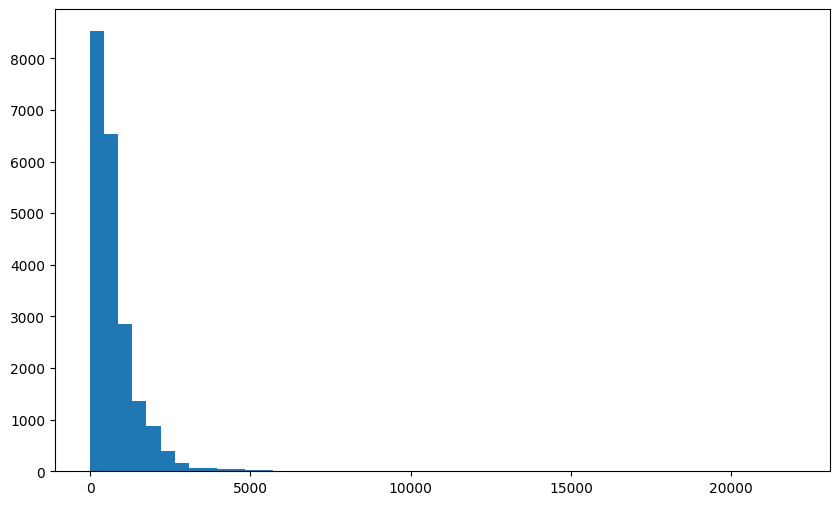

In [66]:
# Write your code here to visualise the data according to the 'Complaint' character length

plt.figure(figsize=(10,6))
# doc_lens = [len(d) for d in data.clean]
doc_lens = [len(d) for d in data.clean]
plt.hist(doc_lens, bins = 50)

In [64]:
data_test.head()

,complaint_text,category,clean,lemma,POS
1,Good morning my name is XXXX XXXX and I apprec...,Debt collection+Credit card debt,good morning name appreciate could help put ...,good morning name appreciate could help put st...,morning name appreciate bank service write cha...
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Credit card or prepaid card+General-purpose cr...,upgrade card tell agent upgrade anniversary ...,upgrade card tell agent upgrade anniversary da...,card agent upgrade anniversary date agent info...
10,Chase Card was reported on XX/XX/2019. However...,"Credit reporting, credit repair services, or o...",chase card report however fraudulent applicati...,chase card report however fraudulent applicati...,chase card report application submit identity ...
11,"On XX/XX/2018, while trying to book a XXXX XX...","Credit reporting, credit repair services, or o...",try book ticket come across offer apply towa...,try book ticket come across offer apply toward...,book ticket offer ticket reward card informati...
14,my grand son give me check for {$1600.00} i de...,Checking or savings account+Checking account,grand son give check deposit chase account fun...,grand son give check deposit chase account fun...,son check deposit chase account fund account m...


# Topic Modelling
### in this dataset I have too much categories, so my plan is to change quantity of categories to 5.
### This can be done by NFM or LDA
###
###
###

##### vectorizer - TFIDF

In [65]:
vectorizer = TfidfVectorizer(min_df=2, max_df=0.95, stop_words='english')
dtm = vectorizer.fit_transform(data['clean']) # document term metrix
# vectorizer.get_feature_names_out()[:10]

In [ ]:
dtm

#
#
#
#
#
# NFM